In [1]:
#!/usr/bin/python3
# coding: utf-8
# prefectures

In [57]:
import codecs
from datetime import datetime as dt
from datetime import timedelta as td
from japanmap import picture
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import os
import pandas as pd
import sys
from cov19utils import create_basic_plot_figure, \
    show_and_clear, moving_average, \
    blank2zero, csv2array, \
    get_twitter, tweet_with_image, \
    get_gpr_predict, FONT_NAME, DT_OFFSET, \
    download_if_needed, json2nparr, code2int, age2int

In [58]:
populations = {}
all_population = 0
with codecs.open("population.txt", encoding='utf-8') as f:
    l = f.readline()
    while l:
        elems = l.split(',')
        populations[elems[3]] = dict(
            region = int(elems[0]),
            code   = int(elems[1]),
            ja     = elems[2],
            en     = elems[3],
            total = int(elems[4])
        )
        all_population += int(elems[4])
        l = f.readline().replace("\r\n", "").rstrip()
print("All population in Japan: {}".format(all_population))

All population in Japan: 127094745


In [59]:
#print(populations)

In [60]:
# 全国情報
ogiwara_uri = "https://raw.githubusercontent.com/kaz-ogiwara/covid19/master/data/"
pref_file = "prefectures.csv"
download_if_needed(ogiwara_uri, pref_file)

In [61]:
offsets = dict(
    year  = 0, # 年
    month = 1, # 月
    day   = 2, # 日
    st_ja = 3, # 都道府県
    st_en = 4, # state
    posis = 5, # 陽性者数
    tests = 6, # 検査数
    hospi = 7, # hospitalized
    serio = 8, # serious
    disch = 9, # discharged
    death =10, # deaths
    ern   =11, # Effective Reproduction Number
)

In [62]:
dt_start = dt.strptime("2020/2/8", "%Y/%m/%d") # 統計開始日
dt_now   = dt.now() # 現在日時
dt_delta = (dt_now - dt_start).days # 差分
n_states = 47 # 都道府県数
erns = [] # ERN 
poss = [] # positives
for i in np.arange(dt_delta):
    erns.append(np.zeros(n_states+1).tolist())
    poss.append(np.zeros(n_states+1).tolist())
    poss[i][0] = erns[i][0] = i

In [63]:
with codecs.open("prefectures.csv", encoding='utf-8') as f:
    l = f.readline()
    cnt = 0
    while l:
        l = f.readline().replace("\r\n", "").rstrip()
        elems = l.split(',')
        if len(elems) < 2:
            continue
        dt_idx  = (dt(int(elems[0]), int(elems[1]), int(elems[2])) - dt_start).days
        st_name = elems[offsets['st_en']]
        st_idx  = populations[st_name]['code']
        erns[dt_idx][st_idx] = blank2zero(elems[offsets['ern']])
        poss[dt_idx][st_idx] = blank2zero(elems[offsets['posis']])
        cnt += 1
print("Load {} lines.".format(cnt))

Load 9772 lines.


In [64]:
erns = np.array(erns)
poss = np.array(poss)
os_idx = -1
for i in np.arange(dt_delta):
    if np.sum(poss[-i -1, 1:])  > 0:
        os_idx = -i -1
        print("Data offset index: {}".format(os_idx))
        break

latest_erns = erns[os_idx] # 最新の実効再生産数
print("latest_erns", latest_erns)
latest_poss = poss[os_idx] # 最新の陽性者数
last1w_poss = poss[os_idx -  7] # 1週間前の陽性者数
last2w_poss = poss[os_idx - 14] # 2週間前の陽性者数
diff1w_poss = latest_poss - last1w_poss # 最新と1週間前の差分
diff2w_poss = latest_poss - last2w_poss # 最新と2週間前の差分
print("diff1w_poss", diff1w_poss[1:])
print("diff2w_poss", diff2w_poss[1:])
# 都道府県別 罹患率
incid1w_rate = np.zeros(n_states + 1).tolist() # 罹患率 (1週足)
incid2w_rate = np.zeros(n_states + 1).tolist() # 罹患率 (2週足)
for k, v in populations.items():
    i = v['code']
    incid1w_rate[i] = (diff1w_poss[i] / v['total']) * 100 # percentage
    incid2w_rate[i] = (diff2w_poss[i] / v['total']) * 100 # percentage
# 簡易罹患率
print("incid1w_rate", incid1w_rate[1:])
print("incid2w_rate", incid2w_rate[1:])

Data offset index: -2
latest_erns [237.     1.16   0.     0.     0.86   0.     0.     0.91   2.5    0.25
   0.47   1.34   1.12   1.21   1.24   0.41   5.54   0.34   0.     0.
   1.64   1.05   2.07   1.1    1.81   1.46   1.08   0.95   1.21   1.44
   1.64   0.     0.     2.45   2.76   0.     0.     0.     0.     0.
   0.9    0.     0.     4.01   0.     0.     0.94   1.8 ]
diff1w_poss [1.190e+02 2.000e+00 0.000e+00 3.000e+01 0.000e+00 0.000e+00 2.100e+01
 3.600e+01 7.000e+00 2.300e+01 1.930e+02 2.220e+02 1.328e+03 4.520e+02
 2.000e+00 1.100e+01 6.000e+00 0.000e+00 1.300e+01 8.000e+00 1.600e+01
 2.500e+01 2.050e+02 3.900e+01 1.700e+01 5.700e+01 3.860e+02 1.140e+02
 1.500e+01 4.000e+00 0.000e+00 0.000e+00 7.000e+00 9.100e+01 6.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 2.600e+01 1.000e+00 2.000e+00
 7.000e+00 0.000e+00 0.000e+00 2.200e+01 1.520e+02]
diff2w_poss [2.160e+02 2.000e+00 0.000e+00 6.700e+01 2.000e+00 0.000e+00 4.500e+01
 4.600e+01 5.700e+01 9.000e+01 3.210e+02 4.120e+02 2.34

In [65]:
def create_basic_scatter_figure(xlabel, ylabel):
    """ 基本散布図テンプレートを作成する """
    plt.close()
    plt.style.use("dark_background")
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111)
    plt.xlabel(xlabel, fontname=FONT_NAME)
    plt.ylabel(ylabel, fontname=FONT_NAME)
    plt.grid(True)
    plt.subplots_adjust(left=0.07, right=0.97, bottom=0.07, top=0.97)
    return fig, ax

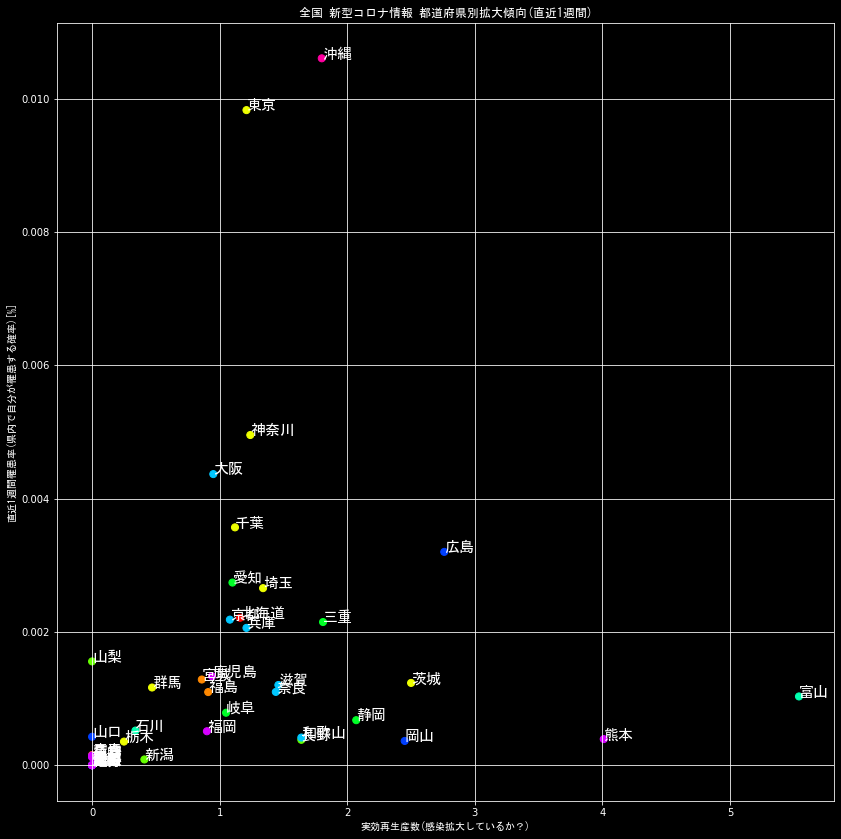

In [66]:
fig, ax = create_basic_scatter_figure("実効再生産数(感染拡大しているか？)", "直近1週間罹患率(県内で自分が罹患する確率)[%]")
cols = [ "#ff0000" for i in range(n_states)]
texts = [ "?" for i in range(n_states)]
for k, v in populations.items():
    cols[v['code'] - 1]  = cm.hsv(v['region'] / 11)
    texts[v['code'] - 1] = v['ja']
plt.scatter(latest_erns[1:], incid1w_rate[1:], s=50, c=cols)
for i in range(n_states):
    ax.annotate(texts[i], xy=(latest_erns[1 + i], incid1w_rate[1 + i]), size=15, fontname=FONT_NAME)
tw_body_1w = '全国 新型コロナ情報 都道府県別拡大傾向(直近1週間)'
plt.title(tw_body_1w, fontname=FONT_NAME)
show_and_clear(fig, "ern-1w_poss.jpg")

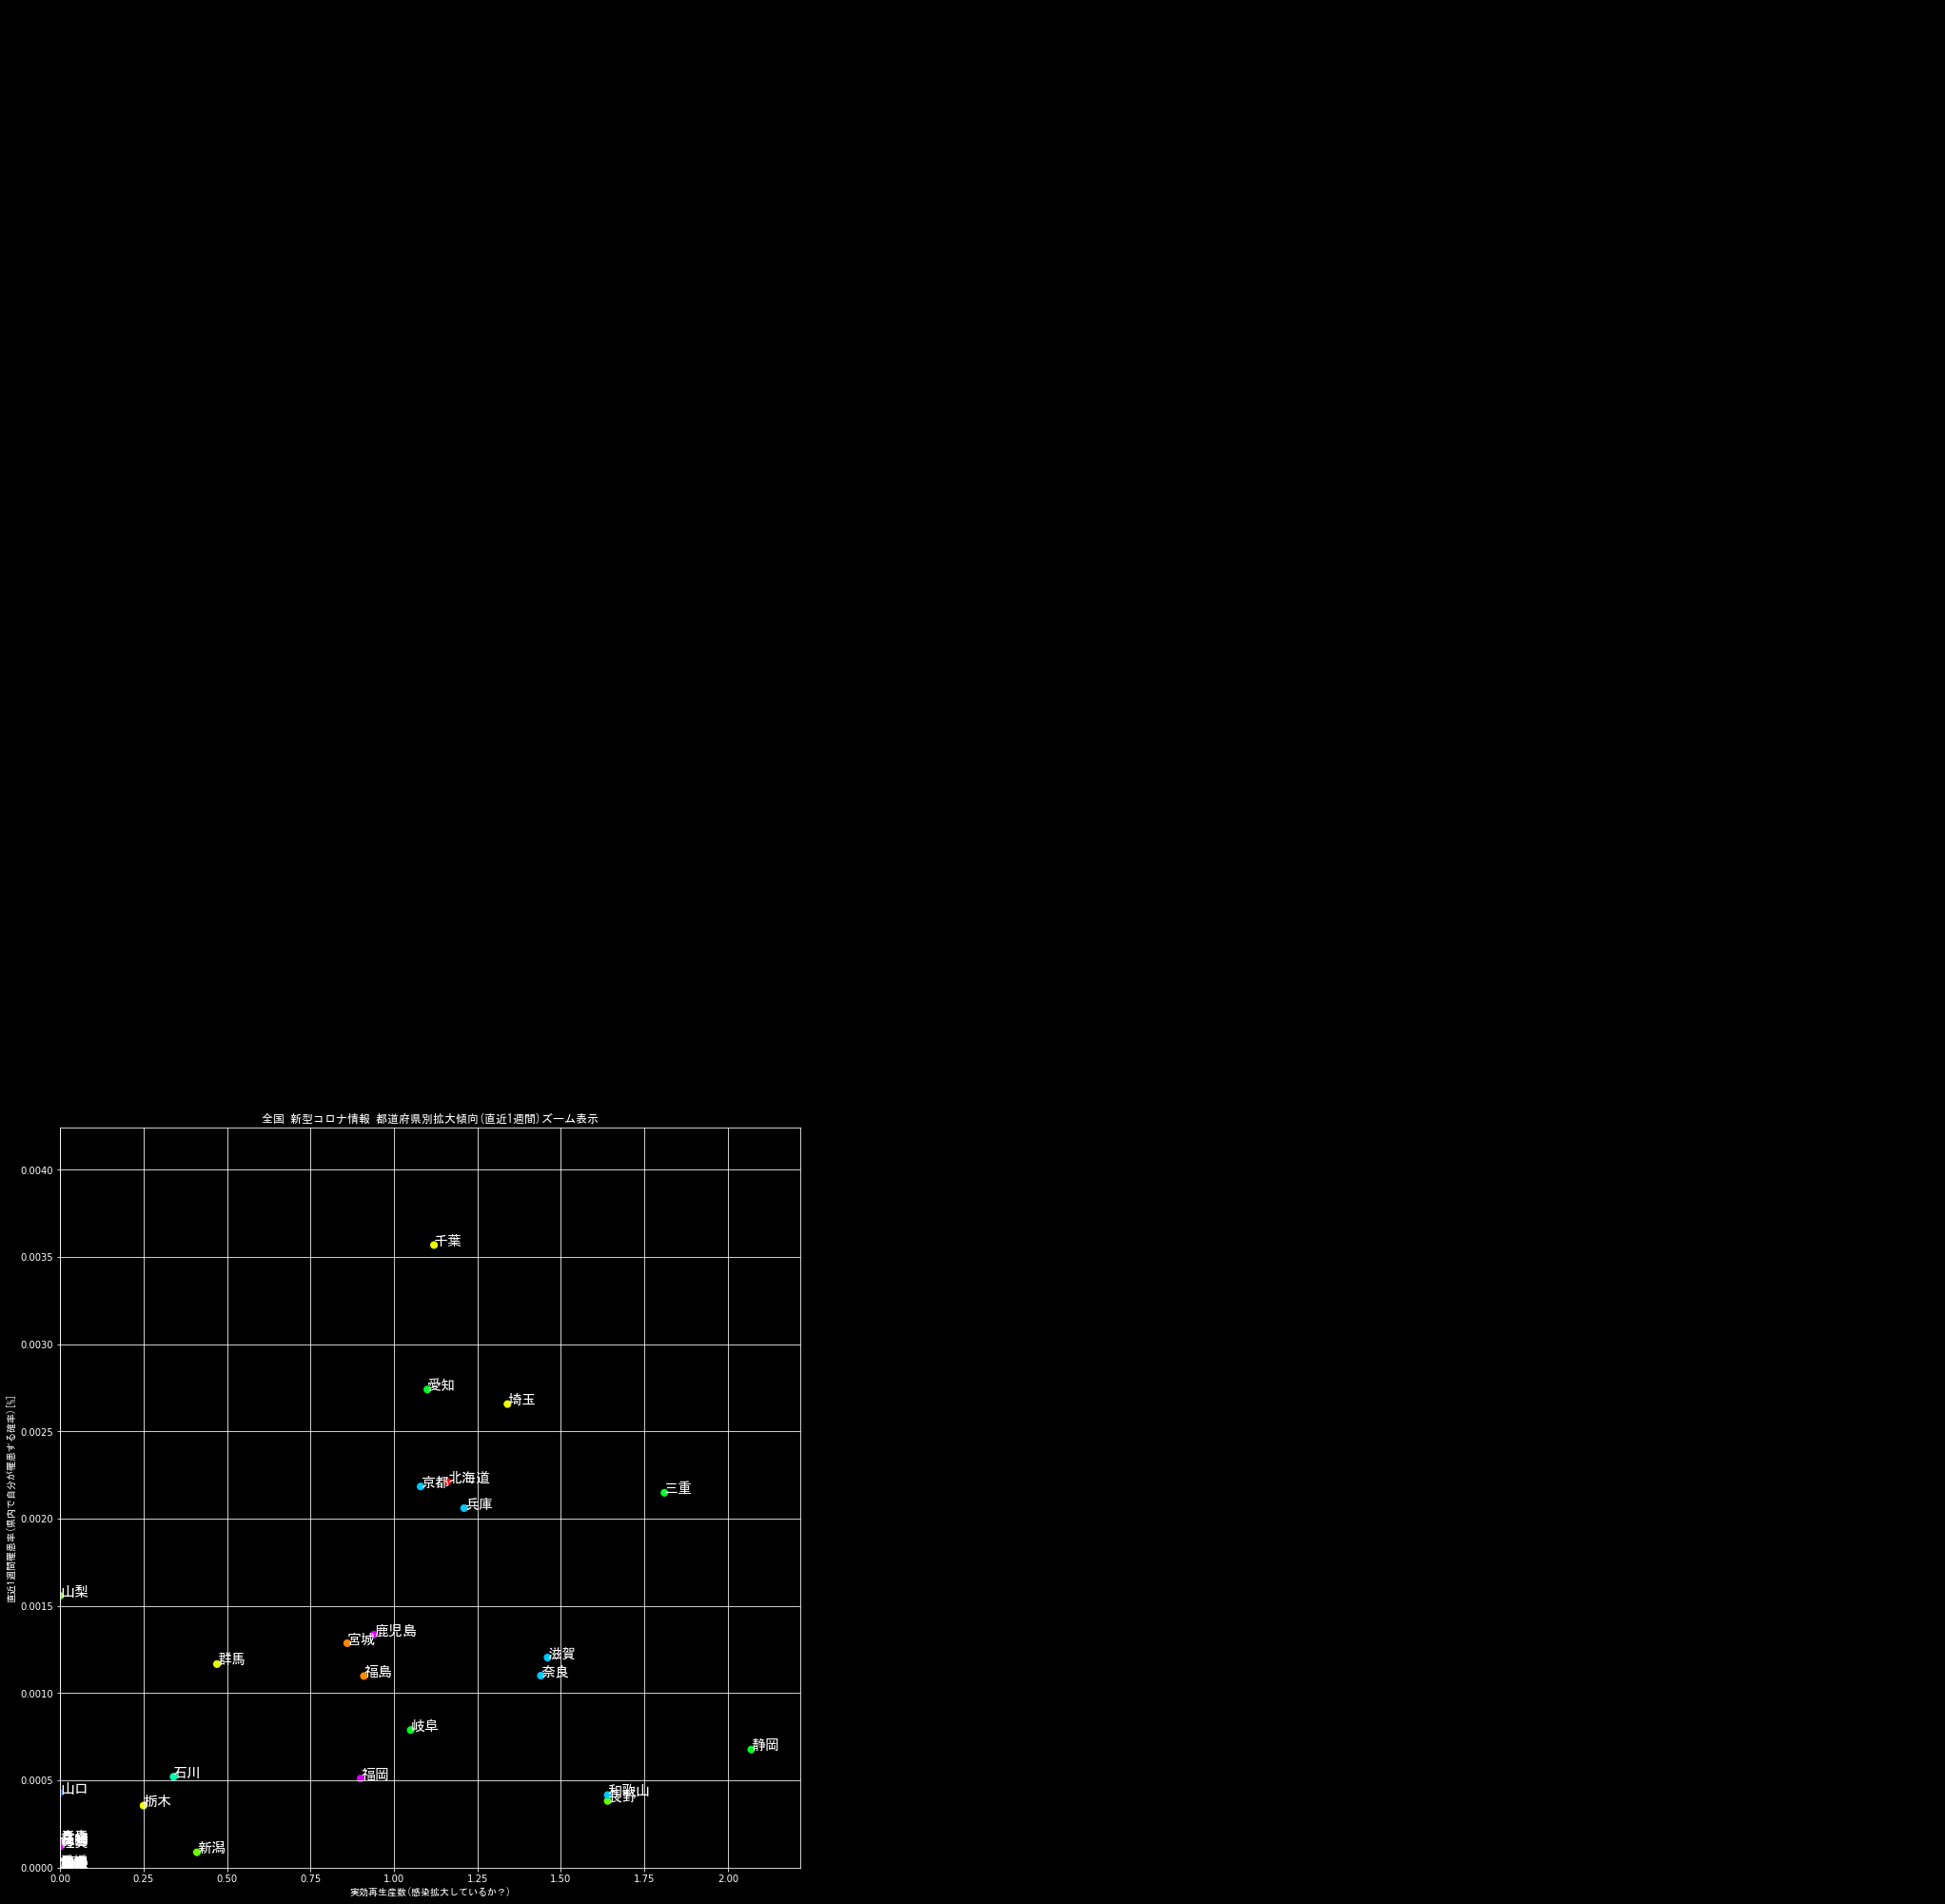

In [67]:
fig, ax = create_basic_scatter_figure("実効再生産数(感染拡大しているか？)", "直近1週間罹患率(県内で自分が罹患する確率)[%]")
plt.xlim(0, np.max(latest_erns[1:]) * 0.4)
plt.ylim(0, np.max(incid1w_rate[1:]) * 0.4)
plt.scatter(latest_erns[1:], incid1w_rate[1:], s=50, c=cols)
for i in range(n_states):
    ax.annotate(texts[i], xy=(latest_erns[1 + i], incid1w_rate[1 + i]), size=15, fontname=FONT_NAME)
tw_body_1w_zoom = '全国 新型コロナ情報 都道府県別拡大傾向(直近1週間)ズーム表示'
plt.title(tw_body_1w_zoom, fontname=FONT_NAME)
show_and_clear(fig, "ern-1w_poss-zoom.jpg")

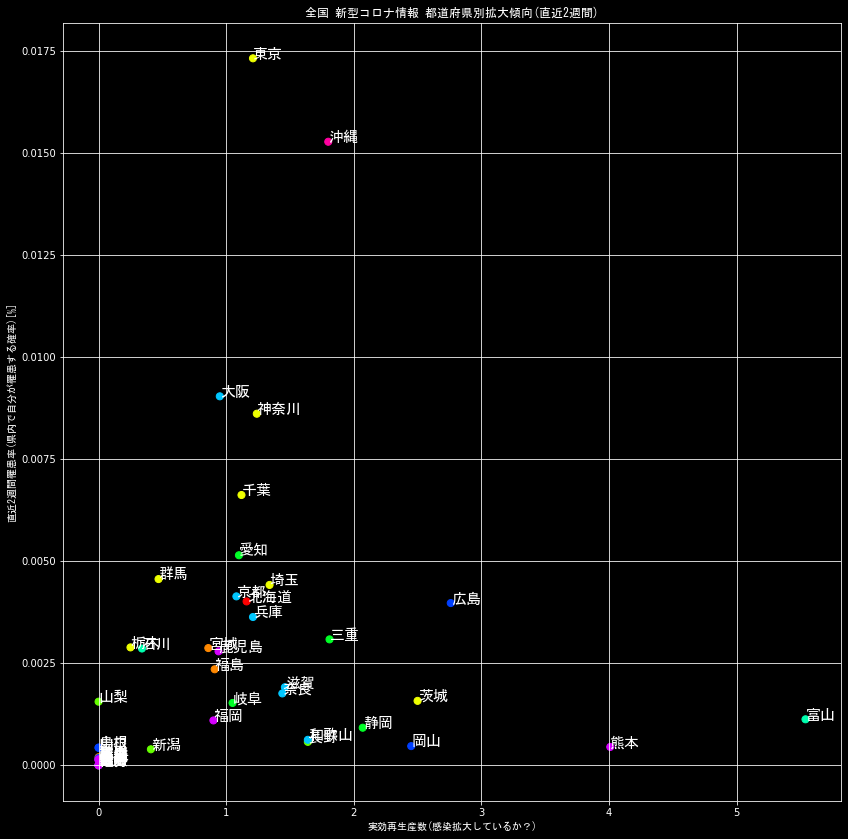

In [68]:
fig, ax = create_basic_scatter_figure("実効再生産数(感染拡大しているか？)", "直近2週間罹患率(県内で自分が罹患する確率)[%]")
plt.scatter(latest_erns[1:], incid2w_rate[1:], s=50, c=cols)
tw_body_2w = '全国 新型コロナ情報 都道府県別拡大傾向(直近2週間)'
plt.title(tw_body_2w, fontname=FONT_NAME)
for i in range(n_states):
    ax.annotate(texts[i], xy=(latest_erns[1 + i], incid2w_rate[1 + i]), size=15, fontname=FONT_NAME)
show_and_clear(fig, "ern-2w_poss.jpg")

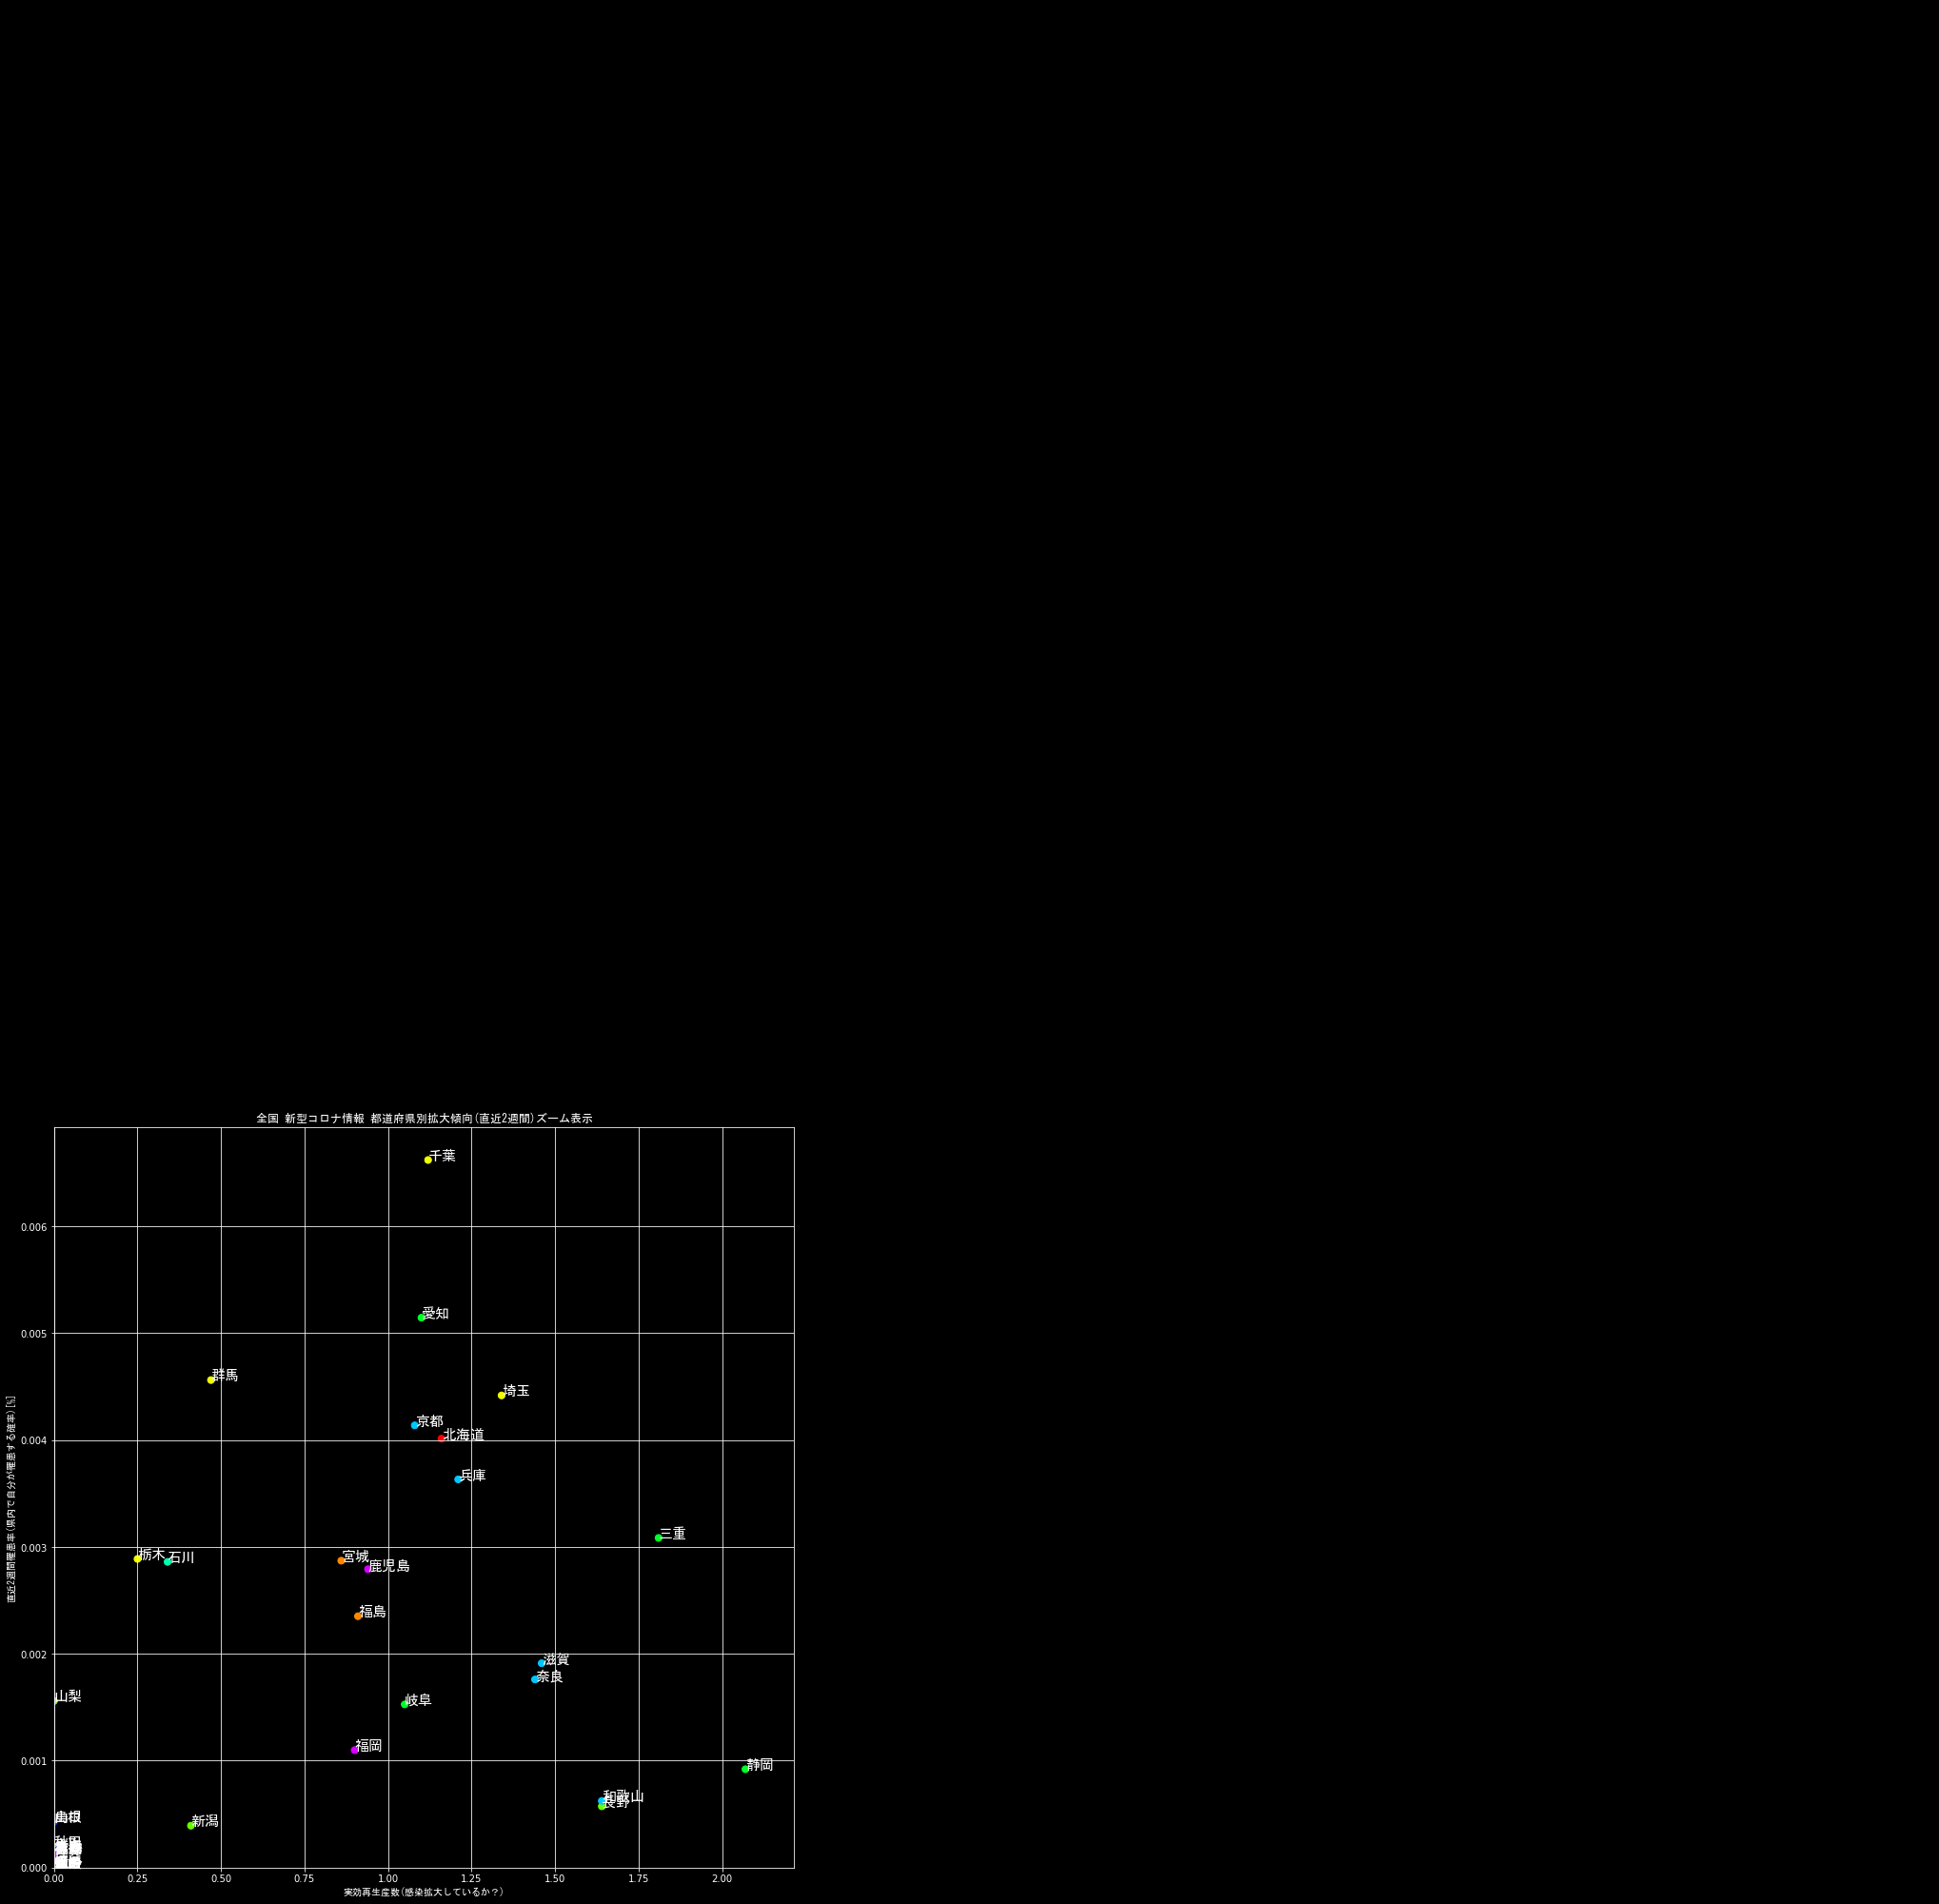

In [69]:
fig, ax = create_basic_scatter_figure("実効再生産数(感染拡大しているか？)", "直近2週間罹患率(県内で自分が罹患する確率)[%]")
plt.xlim(0, np.max(latest_erns[1:]) * 0.4)
plt.ylim(0, np.max(incid2w_rate[1:]) * 0.4)
plt.scatter(latest_erns[1:], incid2w_rate[1:], s=50, c=cols)
for i in range(n_states):
    ax.annotate(texts[i], xy=(latest_erns[1 + i], incid2w_rate[1 + i]), size=15, fontname=FONT_NAME)
tw_body_2w_zoom = '全国 新型コロナ情報 都道府県別拡大傾向(直近2週間)ズーム表示'
plt.title(tw_body_2w_zoom, fontname=FONT_NAME)
show_and_clear(fig, "ern-2w_poss-zoom.jpg")

In [99]:
def mak_japan_heatmap(filename, title, npa1d):
    plt.close()
    plt.style.use("dark_background")
    plt.subplots_adjust(left=0.07, right=0.99, bottom=0.07, top=0.95)
    plt.title(title, fontname=FONT_NAME)
    plt.rcParams['figure.figsize'] = 6, 6
    cmap = plt.get_cmap("Reds")
    norm = plt.Normalize(vmin=np.min(npa1d[1:]), vmax=np.max(npa1d[1:]))
    fcol = lambda x: '#' + bytes(cmap(norm(x), bytes=True)[:3]).hex()
    plt.colorbar(cm.ScalarMappable(norm, cmap))
    map_cols = {}
    for k, v in populations.items():
        map_cols[v['ja']] = fcol(npa1d[v['code']])
    if "ipy" in sys.argv[0]:
        plt.imshow(picture(map_cols))
    plt.savefig(filename)

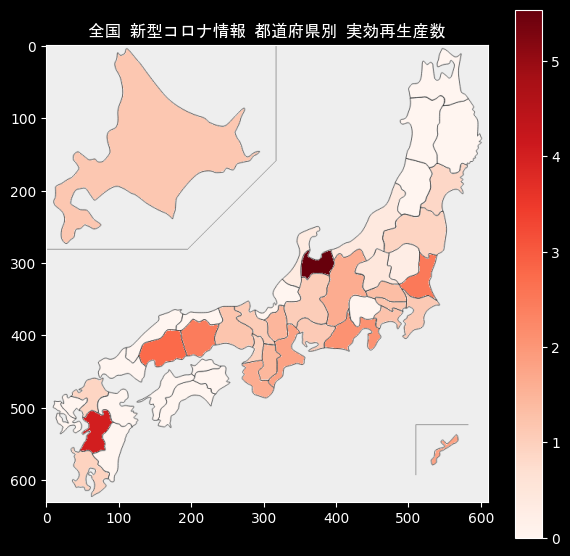

In [100]:
tw_body_map_erns = "全国 新型コロナ情報 都道府県別 実効再生産数"
mak_japan_heatmap('japan-erns.jpg', tw_body_map_erns, latest_erns)

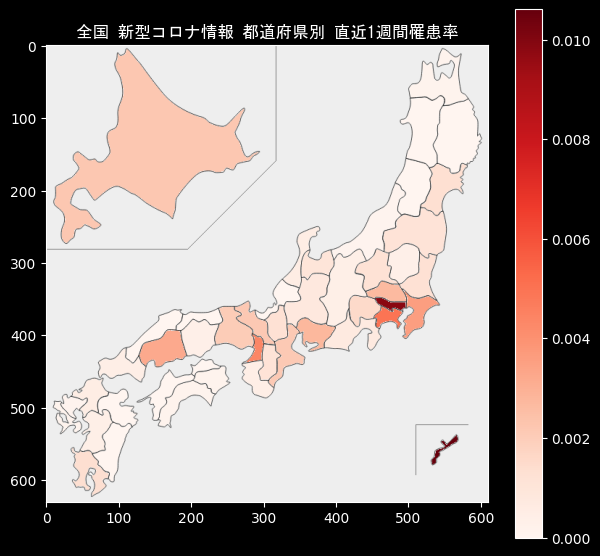

In [101]:
tw_body_map_1w = "全国 新型コロナ情報 都道府県別 直近1週間罹患率"
mak_japan_heatmap('japan-1w.jpg', tw_body_map_1w, incid1w_rate)

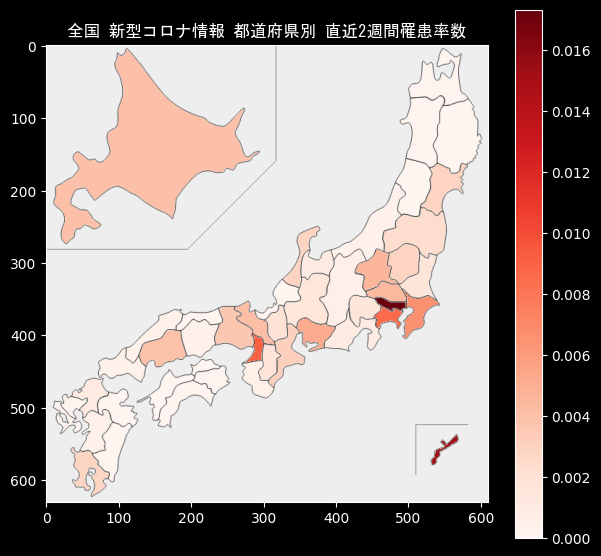

In [102]:
tw_body_map_2w = "全国 新型コロナ情報 都道府県別 直近2週間罹患率数"
mak_japan_heatmap('japan-2w.jpg', tw_body_map_2w, incid2w_rate)

In [103]:
tw = get_twitter()
today_str = dt.now().isoformat()[:19].replace('T', ' ')
tw_body_postfix = " (東洋経済 " + today_str + " 現在)"
tweet_with_image(tw, "ern-1w_poss.jpg", tw_body_1w + tw_body_postfix)
tweet_with_image(tw, "ern-1w_poss-zoom.jpg", tw_body_1w_zoom + tw_body_postfix)
tweet_with_image(tw, "ern-2w_poss.jpg", tw_body_2w + tw_body_postfix)
tweet_with_image(tw, "ern-2w_poss-zoom.jpg", tw_body_2w_zoom + tw_body_postfix)

In [104]:
tweet_with_image(tw, 'japan-erns.jpg', tw_body_map_erns + tw_body_postfix)
tweet_with_image(tw, 'japan-1w.jpg', tw_body_map_1w + tw_body_postfix)
tweet_with_image(tw, 'japan-2w.jpg', tw_body_map_2w + tw_body_postfix)